# Confirmed Cases 

Predicting confirmed cases of Convid-19 with Prophet

In [0]:
import pandas as pd
import numpy as np
from fbprophet import Prophet
import matplotlib.pyplot as plt
 
plt.rcParams['figure.figsize']=(20,10)
plt.style.use('ggplot')

In [0]:
plt.rcParams['figure.figsize']=(20,10)
plt.style.use('ggplot')

In [0]:
pd.plotting.register_matplotlib_converters()

In [0]:
#[3]
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt

%matplotlib inline

In [0]:
from fbprophet import Prophet

import logging
logging.getLogger().setLevel(logging.ERROR)

In [6]:
# this code is used to upload dataset from Pc to colab
from google.colab import files # Please First run this cod in chrom 
def getLocalFiles():
    _files = files.upload() # upload StudentNextSessionf.csv datase
    if len(_files) >0: # Then run above  libray 
       for k,v in _files.items():
         open(k,'wb').write(v)
getLocalFiles()

Saving data_cases1.csv to data_cases1.csv


## Import dataset

In [0]:
data = pd.read_csv('data_cases1.csv', usecols=['Date','Confirmed'],index_col='Date', parse_dates=True )
data.head()

In [0]:
data.head()

In [0]:
data.shape

## Data cleaning and feature engineering

In [0]:
df = data.reset_index()

In [0]:
df.head()

In [0]:
#we get rid of possible duplicates and missing values in the data [3]
df = df[['Date', 'Confirmed']].dropna().drop_duplicates()

In [0]:
df.shape

In [0]:
#we need to convert Date to the datetime format because by default pandas treats this field as string-valued[3]
df['Date'] = pd.to_datetime(df['Date'])

In [0]:
df.head()

In [0]:
#Let's sort the dataframe by time and take a look at what we've got [3]
df.sort_values(by=['Date']).head(n=3)

In [0]:
#We will just trim our time series to keep only those rows that fall onto the period from March 10, 2020 to March 31, 2020[3]
df = df[(df['Date'] > '2020-03-09') & (df['Date'] < '2020-04-01')].sort_values(by=['Date'])
df.head(n=10)

In [0]:
#As we are going to predict the number of confirm Cases of Covid-19, we will aggregate and count unique Cases at each given point in time. We will name the corresponding new column Confirmed_Cases:
aggr_df = df.groupby('Date')[['Confirmed']].count()
aggr_df.columns = ['Confirmed_Cases']

In [0]:
aggr_df.head(n=3)


In [0]:
#In this practice, we are interested in the number of confirmed cases a day. But at this moment all our data is divided into irregular time intervals that are less than a day. 
#This is called a sub-daily time series.To fix this, we need to aggregate the Cases counts by "bins" of a date size. 
#In time series analysis, this process is referred to as resampling. And if we reduce the sampling rate of data it is often called downsampling.
#Luckily, pandas has a built-in functionality for this task. We will resample our time index down to 1-day bins [3]
daily_df = aggr_df.resample('D').apply(sum)
daily_df.head(n=3)

In [0]:
weekly_df = daily_df.resample('W').apply(sum)

In [0]:
weekly_df.head()

In [0]:
daily_df = daily_df.loc[daily_df.index >= '2020-03-10']
daily_df.head(n=3)

In [0]:
plt.figure(figsize=(16,8))
plt.title('Daily Confirmed Cases of COVID-19 (World)')
plt.plot(daily_df['Confirmed_Cases'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Confirmed Cases', fontsize=18)
plt.show()

## Modelling

Let's focus on predictig the confirmed cases of COVI-ID.Prophet's API is very similar to the one you can find in sklearn. First we create a model, then call the method fit, and, finally, make a forecast. The input to the method fit is a DataFrame with two columns:

ds (datestamp) must be of type date or datetime.
y is a numeric value we want to predict.

In [0]:
#[3]
df = daily_df.reset_index()
df.columns = ['ds', 'y']
df.tail(n=3)

In [0]:
df.set_index('ds').y.plot().get_figure()

In [0]:
#To measure the quality of our forecast, we need to split our dataset into the historical part, which is the first and biggest slice of our data,
# and the prediction part, which will be located at the end of the timeline. 
#We will remove the last 3 days from the dataset in order to use it later as a prediction target[3]
prediction_size = 3
train_df = df[:-prediction_size]
train_df.tail(n=3)

In [0]:
# now we create model [3]
m = Prophet()
m.fit(train_df);

In [0]:
#[3]
future = m.make_future_dataframe(periods=prediction_size)
future.tail(n=3)

In [67]:
#[3]
forecast = m.predict(future)
forecast.tail(n=3)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
14,2020-03-24,96.015084,71.563744,119.940583,96.015084,96.015085,0.0,0.0,0.0,0.0,0.0,0.0,96.015084
15,2020-03-25,102.267617,79.103752,126.790716,102.267616,102.267617,0.0,0.0,0.0,0.0,0.0,0.0,102.267617
16,2020-03-26,108.520149,87.350423,132.865530,108.520149,108.520150,0.0,0.0,0.0,0.0,0.0,0.0,108.520149


In [0]:
#[1]
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

## Result Visualization

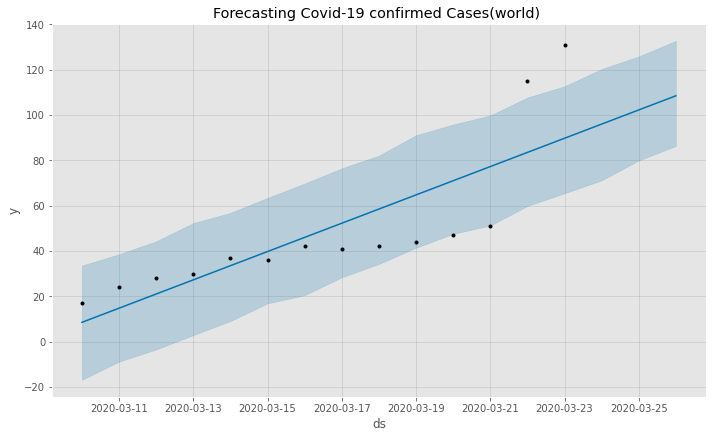

In [34]:
#[3]forecasting
m.plot(forecast);
plt.title("Forecasting Covid-19 confirmed Cases(world) ")
plt.show()

In [0]:
#[3]
m.plot_components(forecast);
plt.show()

In [0]:
# [1]
df.set_index('ds', inplace=True)
forecast.set_index('ds', inplace=True)

In [0]:
viz_df = daily_df.join(forecast[['yhat', 'yhat_lower','yhat_upper']], how = 'outer')

In [38]:
viz_df.head()

,Confirmed_Cases,yhat,yhat_lower,yhat_upper
Date,,,,
2020-03-10,17,8.479636,-16.910929,33.552142
2020-03-11,24,14.732168,-8.852422,38.555248
2020-03-12,28,20.984699,-3.516432,44.257491
2020-03-13,30,27.237231,2.839432,52.304972
2020-03-14,37,33.489763,9.061280,56.830262


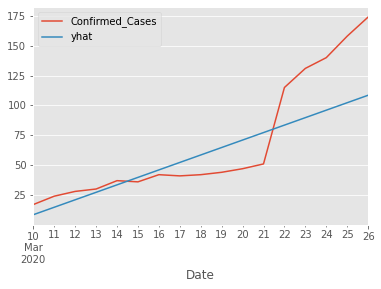

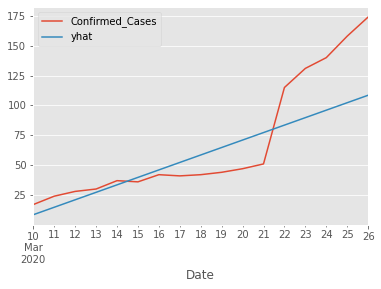

In [39]:
viz_df[['Confirmed_Cases', 'yhat']].plot().get_figure()

## Forecast quality evaluation 
Let's evaluate the quality of the algorithm by calculating the error metrics for the last 30 days that we predicted. For this, we will need the observations  yi  and the corresponding predicted values  y^i .

In [0]:
def make_comparison_dataframe(historical, forecast):
    """Join the history with the forecast.
    
       The resulting dataset will contain columns 'yhat', 'yhat_lower', 'yhat_upper' and 'y'.
    """
    return forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(historical.set_index('ds'))

In [69]:
cmp_df = make_comparison_dataframe(df, forecast)
cmp_df.tail(n=3)

,yhat,yhat_lower,yhat_upper,y
ds,,,,
2020-03-24,96.015084,71.563744,119.940583,140
2020-03-25,102.267617,79.103752,126.790716,158
2020-03-26,108.520149,87.350423,132.865530,174


In [0]:
def calculate_forecast_errors(df, prediction_size):
    """Calculate MAPE and MAE of the forecast.
    
       Args:
           df: joined dataset with 'y' and 'yhat' columns.
           prediction_size: number of days at the end to predict.
    """
    
    # Make a copy
    df = df.copy()
    
    # Now we calculate the values of e_i and p_i according to the formulas given in the article above.
    df['e'] = df['y'] - df['yhat']
    df['p'] = 100 * df['e'] / df['y']
    
    # Recall that we held out the values of the last `prediction_size` days
    # in order to predict them and measure the quality of the model. 
    
    # Now cut out the part of the data which we made our prediction for.
    predicted_part = df[-prediction_size:]
    
    # Define the function that averages absolute error values over the predicted part.
    error_mean = lambda error_name: np.mean(np.abs(predicted_part[error_name]))
    
    # Now we can calculate MAPE and MAE and return the resulting dictionary of errors.
    return {'MAPE': error_mean('p'), 'MAE': error_mean('e')}


In [71]:
for err_name, err_value in calculate_forecast_errors(cmp_df, prediction_size).items():
    print(err_name, err_value)

MAPE 34.774518380154696
MAE 55.0657164657149


## References 

In [0]:
#[1]Forecasting Time Series Data With Prophet I & II
# https://nextjournal.com/eric-brown/forecasting-with-prophet 
#[2]Forecasting Time Series Data With Prophet IV
#https://nextjournal.com/eric-brown/forecasting-with-prophet-part-4
#[3]Time series analysis in Python
#https://mlcourse.ai/articles/topic9-part2-prophet/
#https://www.kaggle.com/kashnitsky/topic-9-part-2-time-series-with-facebook-prophet